# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Домашнее задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
    - https://www.kaggle.com/carlolepelaars/camvid
    - https://www.kaggle.com/dansbecker/cityscapes-image-pairs
    - https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset
    - https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy
    - https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels
2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

Использовал датасет https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**U-net ANN**

In this notebook we train a complicated network with the help of the skip connections like in Res-Net. 
The purpose of the network is image segmentation, i.e. identification of particular shapes in the images. We use the https://www.cityscapes-dataset.com/ dataset, uploaded to Kaggle https://www.kaggle.com/dansbecker/cityscapes-image-pairs. This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

(256, 512, 3)
2975


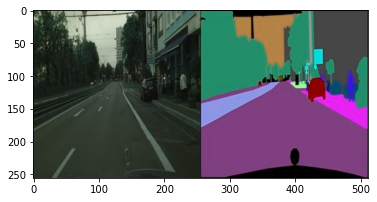

In [2]:
#Reading data. Before running this code, the dataset should be added to the notebook using the Kaggle functionality (or by any other means). In this block we read the first image
#and make sure everything works
path = '../input/cityscapes-image-pairs/cityscapes_data/train/'
flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [3]:
#reading the actual images and forming them into the training dataset
szy,szx,_ = np.shape(img0)
N_ex = 1500
N_bias = 0
x_train = np.zeros((N_ex,szy,int(szx/2),3))
y_train = np.zeros((N_ex,szy,int(szx/2),3))
k = 0;

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.imread(path+f)[:,:256]/256
    y_train[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

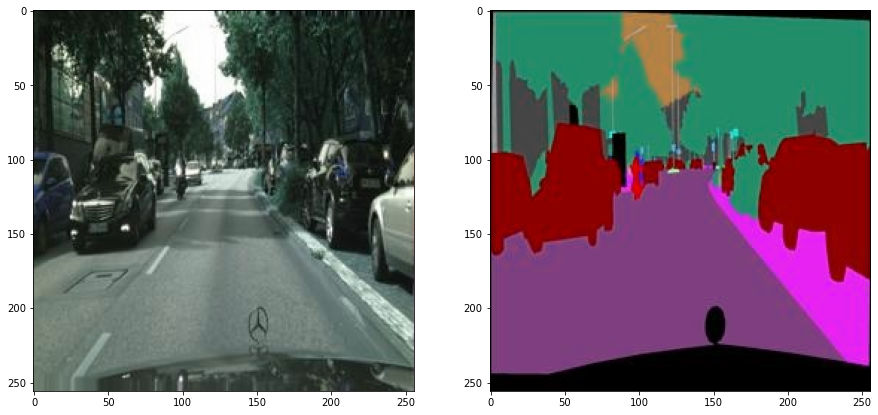

In [4]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[1])
plt.subplot(1,2,2)
plt.imshow(y_train[1])

In [5]:
#same for the validation data
path = '../input/cityscapes-image-pairs/cityscapes_data/val/'
flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 100

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_val[k] = cv2.imread(path+f)[:,:256]/256
    y_val[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

In [6]:
#u-net architecture
import tensorflow as tf
import keras

from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2


# define conv_factory: batch normalization + ReLU + Conv2D + Dropout (optional)
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
  
    return x


# define dense block: a nb_layers stack of conv_factory layers merged together
def denseblock(x, concat_axis, nb_layers, growth_rate, dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,dropout_rate, weight_decay)
        list_feat.append(x)
    x = Concatenate(axis=concat_axis)(list_feat)

    return x


# define model U-net modified with dense block
def u_net():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape) #input layer

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
#################this is the bottleneck######################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)]) #skip connection db4 to up5
    print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)]) #skip connection db3 to up6
    print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)]) #skip connection db2 to up7
    print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)]) #skip connection db1 to up8
    print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9) # final node layer
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)  #output layer matched in size with the input
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11) 
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [7]:
model = u_net()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
merge5 shape: (None, 32, 32, 576)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
merge6 shape: (None, 64, 64, 320)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
merge7 shape: (None, 128, 128, 192)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
merge8 shape: (None, 256, 256, 128)
conv9 shape: (None, 256, 256, 32)
db9 shape: (No

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
 hist = model.fit(x_train, y_train, epochs=20, shuffle = True, batch_size= 10, validation_data=(x_val, y_val))

Epoch 1/20
150/150 [==============================] - 56s 373ms/step - loss: 0.2428 - val_loss: 0.2067
Epoch 2/20
150/150 [==============================] - 54s 361ms/step - loss: 0.1566 - val_loss: 0.1687
Epoch 3/20
150/150 [==============================] - 54s 360ms/step - loss: 0.1134 - val_loss: 0.1076
Epoch 4/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0819 - val_loss: 0.0793
Epoch 5/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 6/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0435 - val_loss: 0.0498
Epoch 7/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0323 - val_loss: 0.0354
Epoch 8/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0252 - val_loss: 0.0267
Epoch 9/20
150/150 [==============================] - 54s 360ms/step - loss: 0.0207 - val_loss: 0.0232
Epoch 10/20
150/150 [==============================] - 54s 360ms/step - l

In [10]:
 pp = model.predict(x_val[0:20,:,:,:])

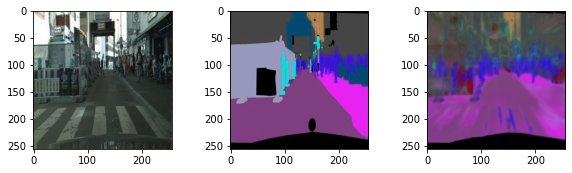

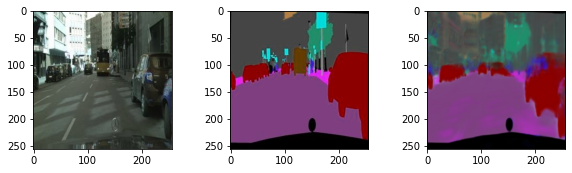

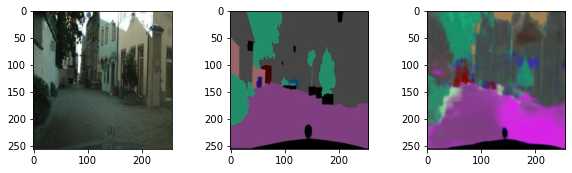

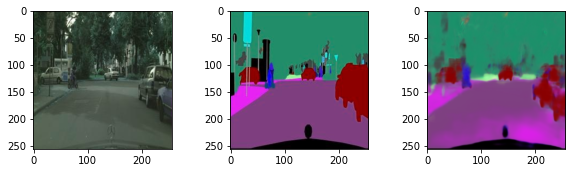

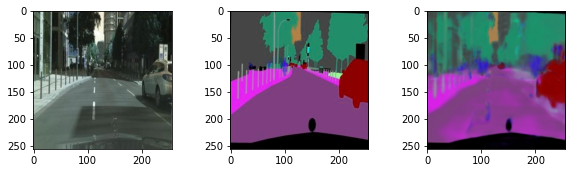

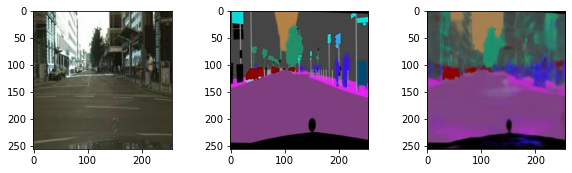

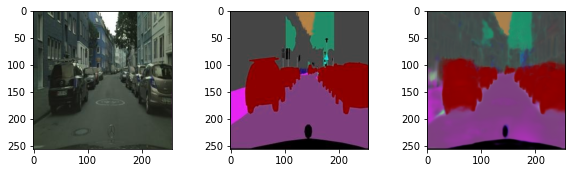

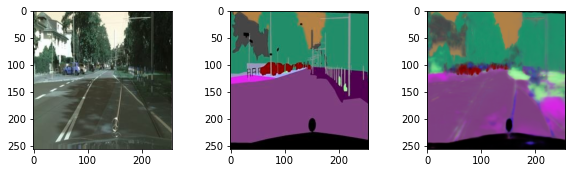

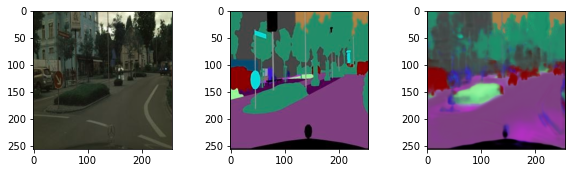

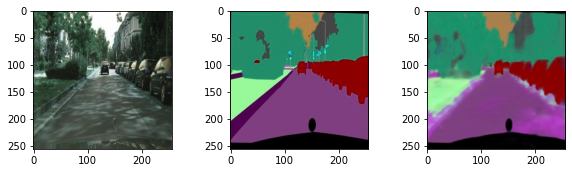

In [11]:
#show the result
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])


In [12]:
#the same model, but without the skip connections
def u_net_wihtout_skips():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape)

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
###############################################################################################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    #merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)])
    #print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5) #was merge5
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    #merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)])
    #print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)#was merge6
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    #merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)])
    #print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7) #was merge7
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    #merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)])
    #print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)#was merge8
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9)
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11)
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [13]:
model_nc = u_net_wihtout_skips()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
conv9 shape: (None, 256, 256, 32)
db9 shape: (None, 256, 256, 64)
conv10 shape: (None, 256, 256, 16)
conv11 shape: (None, 256, 256, 3)


In [14]:
model_nc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 32) 128         conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 256, 256, 32) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [15]:
his_nc = model_nc.fit(x_train, y_train, epochs=20, shuffle = True, batch_size= 10, validation_data=(x_val, y_val))

Epoch 1/20
150/150 [==============================] - 49s 327ms/step - loss: 0.2734 - val_loss: 0.2249
Epoch 2/20
150/150 [==============================] - 47s 316ms/step - loss: 0.1715 - val_loss: 0.1557
Epoch 3/20
150/150 [==============================] - 48s 317ms/step - loss: 0.1217 - val_loss: 0.1096
Epoch 4/20
150/150 [==============================] - 48s 317ms/step - loss: 0.0884 - val_loss: 0.0911
Epoch 5/20
150/150 [==============================] - 47s 317ms/step - loss: 0.0642 - val_loss: 0.0585
Epoch 6/20
150/150 [==============================] - 48s 318ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 7/20
150/150 [==============================] - 47s 316ms/step - loss: 0.0356 - val_loss: 0.0350
Epoch 8/20
150/150 [==============================] - 48s 317ms/step - loss: 0.0282 - val_loss: 0.0283
Epoch 9/20
150/150 [==============================] - 48s 317ms/step - loss: 0.0232 - val_loss: 0.0249
Epoch 10/20
150/150 [==============================] - 48s 317ms/step - l

In [16]:
 pp_nc = model_nc.predict(x_val[0:20,:,:,:])

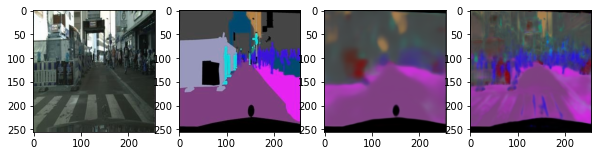

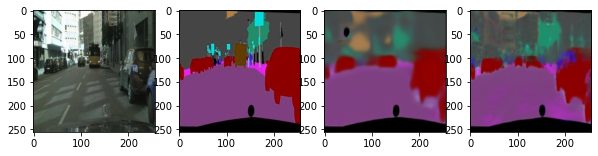

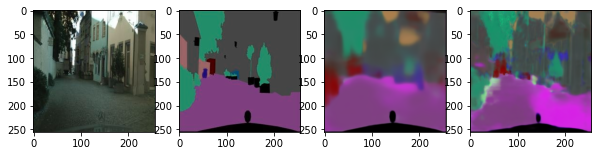

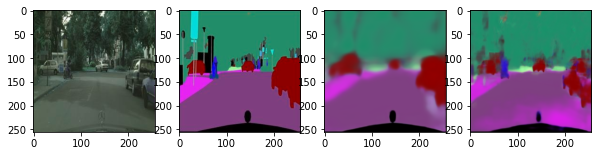

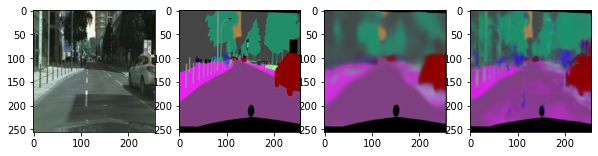

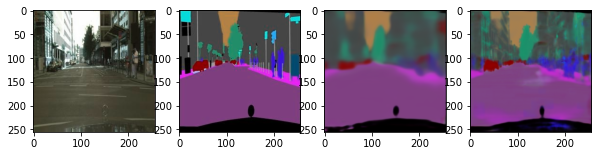

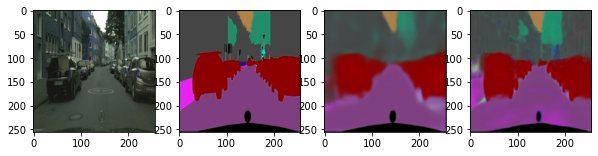

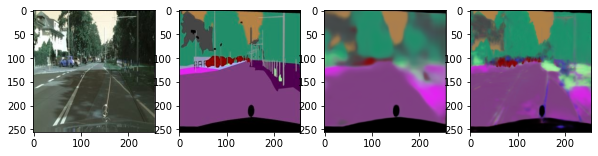

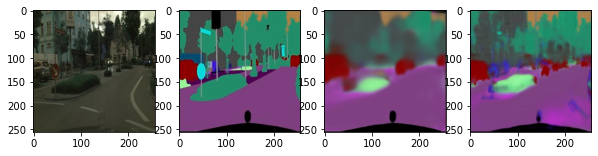

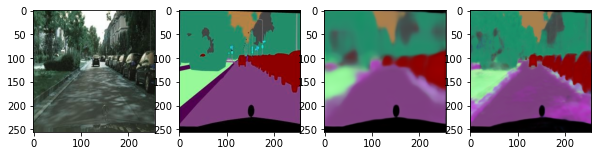

In [17]:
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])
    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])
    plt.subplot(ni,4,3+k*4)
    plt.imshow(pp_nc[k]) #without skips
    plt.subplot(ni,4,4+k*4)
    plt.imshow(pp[k]) #with skips


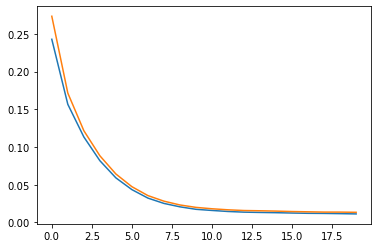

In [18]:
#training mse
plt.plot(hist.history['loss'])
plt.plot(his_nc.history['loss'])

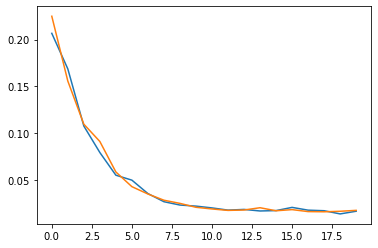

In [19]:
#validation mse
plt.plot(hist.history['val_loss'])
plt.plot(his_nc.history['val_loss'])